In [2]:
import pathlib
import os

import h5py
import pandas as pd
import json
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import dask.array as da
import dask.dataframe as dd
import skimage 


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [3]:
date = "15_12_2023"
genotype = "R40D05_sytjGCaMP7f_CsChrimsontdT"
fly = "fly3"
session = 'rglom2_stim-001'
basedir = pathlib.PurePath(f'/media/mplitt/SSD_storage1/2PData/{genotype}/{date}/{fly}/{session}/')
basename_input = pathlib.Path(basedir.joinpath(session))
metadata = st2p.preprocessing.bruker_metadata.read(basename_input)

h5name = f'/media/mplitt/SSD_storage1/2P_scratch/{genotype}/{date}/{fly}/{session}/data.h5'
if not os.path.exists(h5name):
    tiff_data = st2p.preprocessing.tiff_tools.read(basename_input, 
                                            metadata['size'],metadata['layout'], first_chan=1)
    st2p.preprocessing.tiff_tools.convert_to_hdf5(tiff_data,h5name, overwrite=True)

(207, 325)
[########################################] | 100% Completed | 24.45 s


In [4]:
f = h5py.File(h5name)
data = f['/data'][:]

ref_img = st2p.preprocessing.motion_correction.make_ref_img(data,0)
data_corr, shifts, error, diffphase = st2p.preprocessing.motion_correction.align_data_chunk(data, ref_img[1,:,:,:], in_place=False)

[]

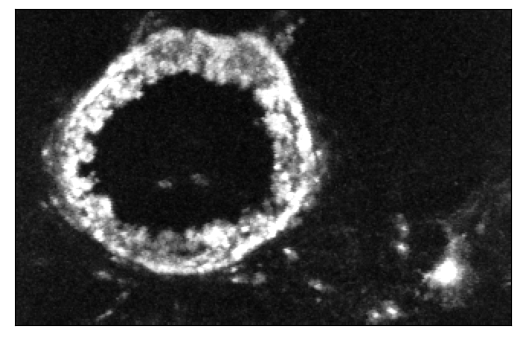

In [5]:
fig, ax = plt.subplots()
# ax.imshow(ref_img[0,:,:,:].max(axis=0), cmap='Greys_r')
im = data_corr[1,:,:,:,:].mean(axis=0).max(axis=0)
ax.imshow(im, cmap='Greys_r', vmax = np.percentile(im,98),vmin=np.percentile(im,0))
ax.set_xticks([])
ax.set_yticks([])


In [6]:
data_corr.shape

(2, 1749, 4, 207, 325)

In [7]:
eb_napari = st2p.preprocessing.napari_tools.EllipsoidBodySession().new_session(data_corr.mean(axis=1))

In [8]:
napari_outputs_file = f'/media/mplitt/SSD_storage1/2P_scratch/{genotype}/{date}/{fly}/{session}/napari.pkl'

In [8]:
# eb_napari = st2p.preprocessing.napari_tools.EllipsoidBodySession()
# eb_napari.open_existing_session(napari_outputs_file)

# masks = eb_napari.masks
# bckgnd = eb_napari.background.data

In [9]:
eb_napari.viewer.add_labels((0*eb_napari.ref_img[0,:,:,:]).astype(int), name='glomeruli')


<Labels layer 'glomeruli' at 0x7fecfedd5f90>

In [10]:
eb_napari.make_phase_masks(n_rois=16)
masks = eb_napari.masks
glomeruli = eb_napari.viewer.layers['glomeruli'].data
outer_ring = eb_napari.outer_ring.data
bckgnd = eb_napari.background.data
eb_napari.save_layers(napari_outputs_file)


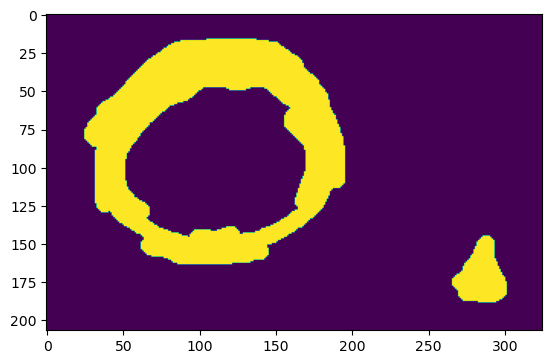

In [11]:
glom_mask = glomeruli>0
outer_ring_mask = outer_ring>0

neuropil_mask = glom_mask+outer_ring_mask

fig, ax = plt.subplots()
ax.imshow(neuropil_mask[0,:,:])

In [12]:
# make new napari  with glomeruli layer

# mark glomeruli

In [13]:
# for each pixel, regress out the average timecourse for that line (mask out neuropil)

import sklearn
from sklearn.linear_model import LinearRegression as LinReg

data_noart = np.nan*data_corr
# F  = F - 0*notF[:, np.newaxis,:]
for ch in range(data_corr.shape[0]):
    for z in range(data_corr.shape[2]):
        for row in range(data_corr.shape[3]):
            dat = data_corr[ch,:,z,row,:]
            npil_mask = neuropil_mask[z,row,:]
            
            not_npil_dat = dat[:,~npil_mask].mean(axis=-1)
            
            lr =  LinReg().fit(not_npil_dat[:,np.newaxis], dat)
            data_noart[ch, :, z, row, :] = data_corr[ch, :, z, row, :] - lr.predict(not_npil_dat[:, np.newaxis])
            # data_noart[ch, :, z, row, :] = data_corr[ch, :, z, row, :] - .9*not_npil_dat[:, np.newaxis]
            
#     for row in range(F.shape[
#     lr = LinReg().fit(notF[ch,np.newaxis, :].T, F[ch,:,:].T)
#     F[ch,:,:] = F[ch,:,:]-coef*lr.predict(notF[ch,np.newaxis,:].T).T  #+ lr.intercept_[:,np.newaxis]
    
# F[nanmask]=np.nan
# data_corr.shape


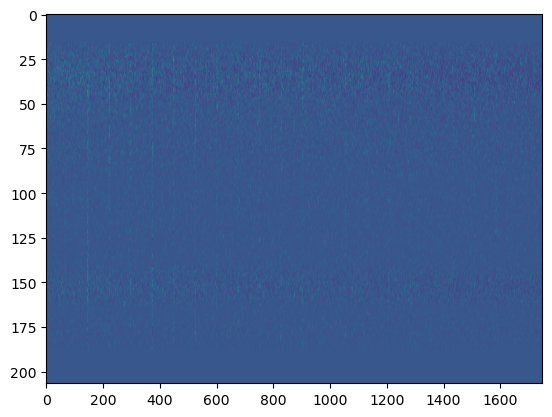

In [14]:
%matplotlib inline
fig, ax = plt.subplots()
ax.imshow(data_noart[1,:,0,:,:].mean(axis=2).T, aspect='auto')

In [15]:
F, notF = st2p.preprocessing.signals.extract_2p_timeseries(data_noart, masks, 16, bckgnd_mask=bckgnd, max_proj=False) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [16]:
F.shape

(2, 16, 1749)

In [17]:
# F_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.median_filter(F,(1,1,3)),1,axis=-1)
F_sm = sp.ndimage.median_filter(F,(1,1,11))

In [18]:
dff = sp.stats.zscore(F[1,:,:],axis=-1)

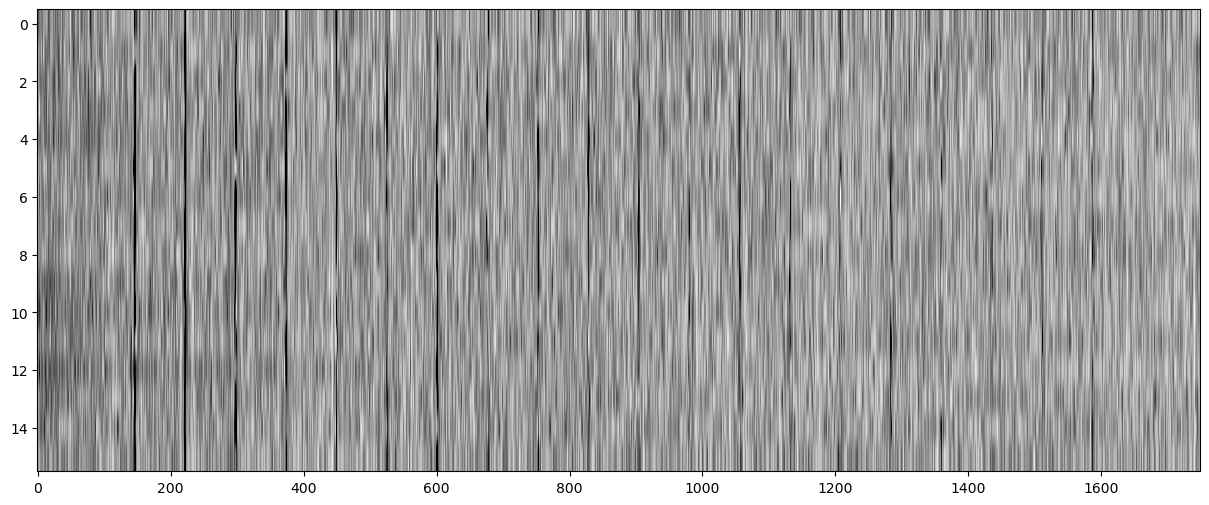

In [19]:
%matplotlib inline
fig, ax = plt.subplots(sharex=True, figsize = [15,6])
ax.imshow(dff, aspect='auto', cmap = 'Greys', vmin=-3, vmax=3)

In [21]:
%matplotlib qt
mtmp = metadata['mark_points']
stim_times = (mtmp['inter_point_delay'] + mtmp['duration'])*np.ones([mtmp['repetitions'],])

stim_times[0]=0
stim_times = (np.cumsum(stim_times) + mtmp['initial_delay'] +  mtmp['duration'])/1000
print(stim_times)


frame_times = np.array(metadata['frame_times']).mean(axis=-1)
fig, ax = plt.subplots()
ax.plot(frame_times, np.nanmean(dff, axis=0))

for s in stim_times:
    ax.plot([s,s],[-1, 4],color='orange', zorder=-10)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Z-score F')

[ 10.2  15.4  20.6  25.8  31.   36.2  41.4  46.6  51.8  57.   62.2  67.4
  72.6  77.8  83.   88.2  93.4  98.6 103.8 109. ]


Text(0, 0.5, 'Z-score F')

In [21]:
metadata['mark_points']

{'iterations': 1,
 'iteration_delay': 1000.0,
 'repetitions': 20,
 'uncaging_laser': 'Axon 1064',
 'trigger': 'None',
 'trigger_freq': 'None',
 'trigger_count': 1,
 'uncaging_power': 150,
 'custom_laser_power': None,
 'initial_delay': 10000.0,
 'inter_point_delay': 5000.0,
 'duration': 200.0,
 'spiral_revolutions': 5.0,
 'indices': '10',
 'points_list': [{'Index': 10.0,
   'X': 0.878917121792241,
   'Y': 0.821815046323601,
   'IsSpiral': True,
   'SpiralWidth': 0.0369563833927507,
   'SpiralHeight': 0.0580233072591497,
   'SpiralSizeInMicrons': 5.0}]}

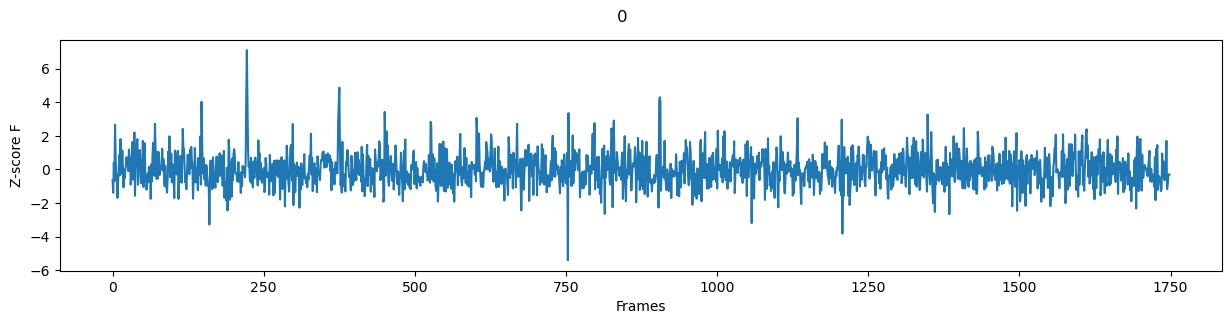

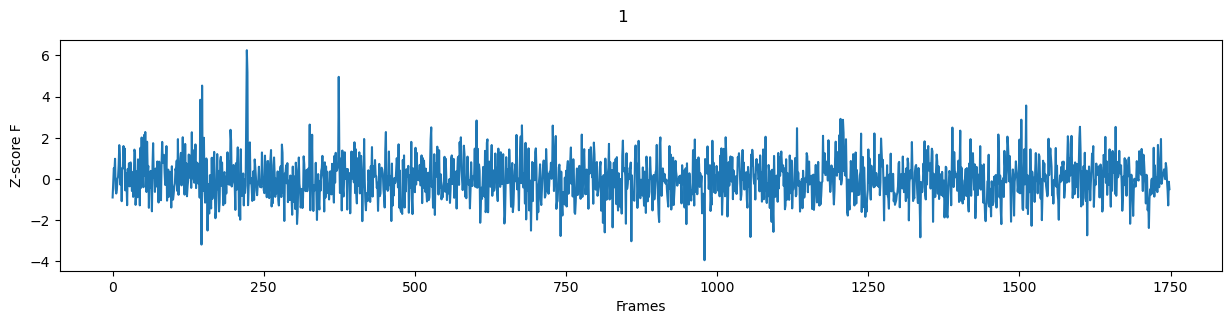

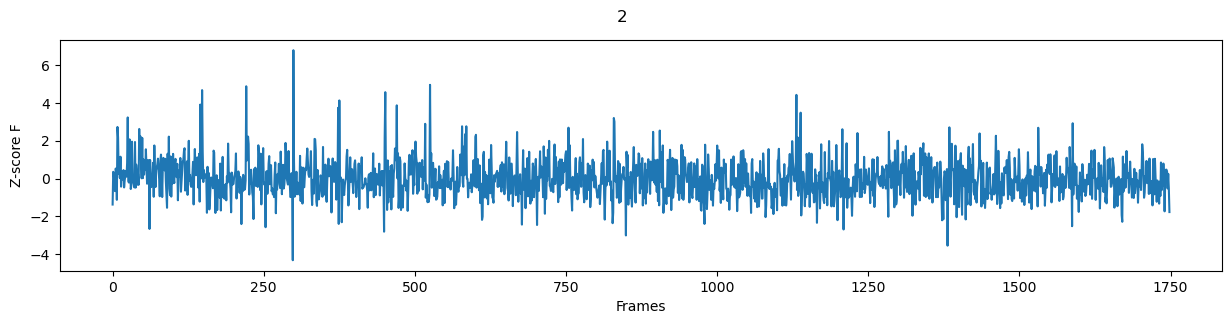

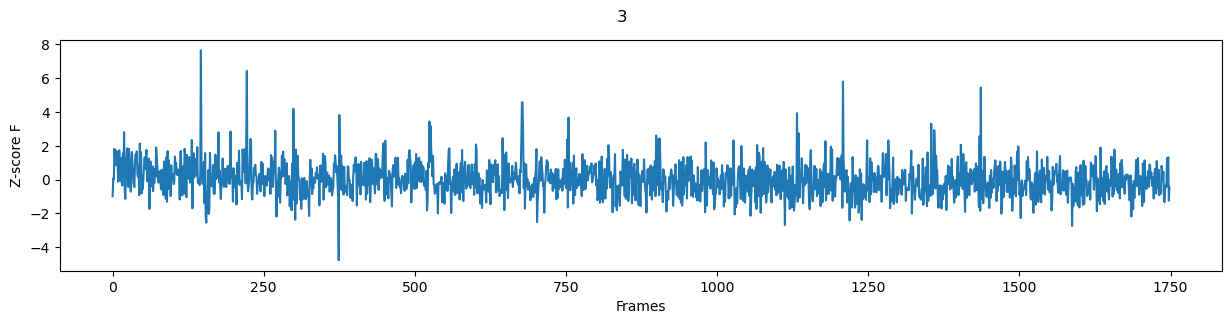

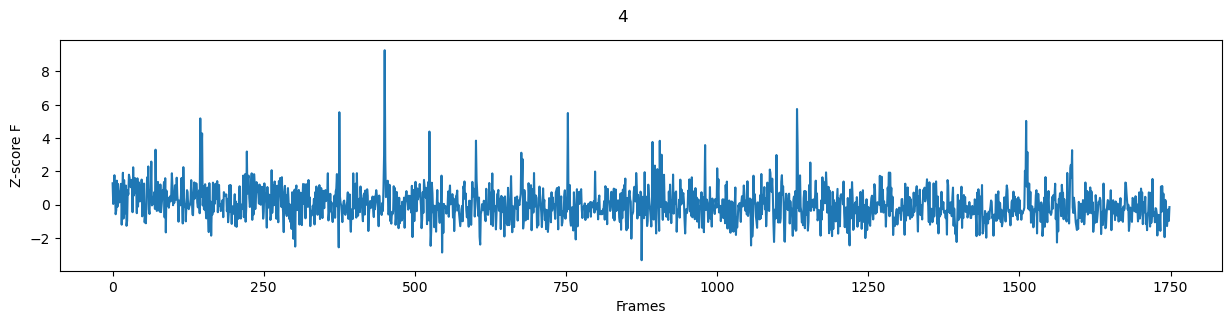

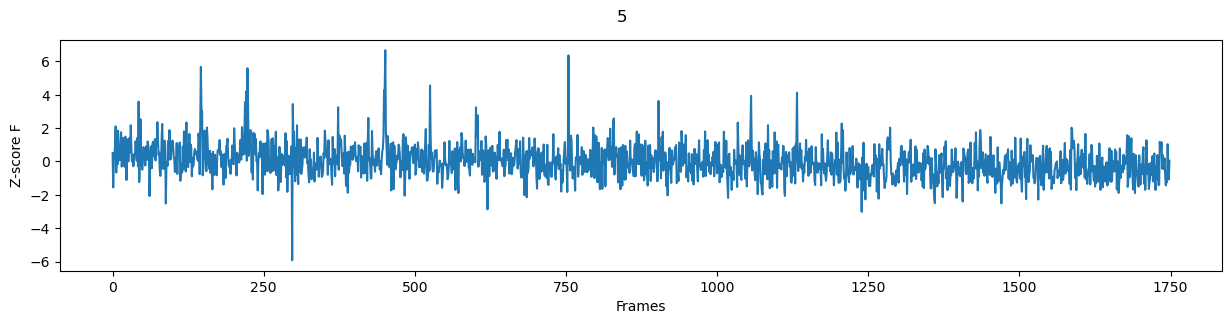

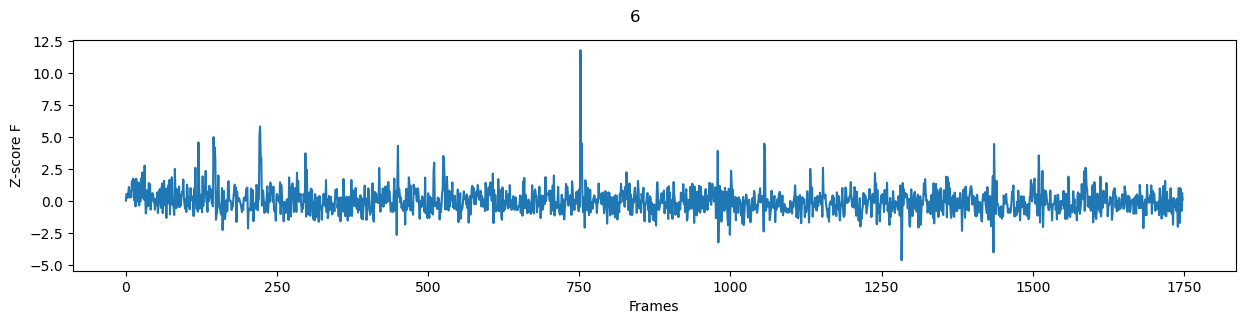

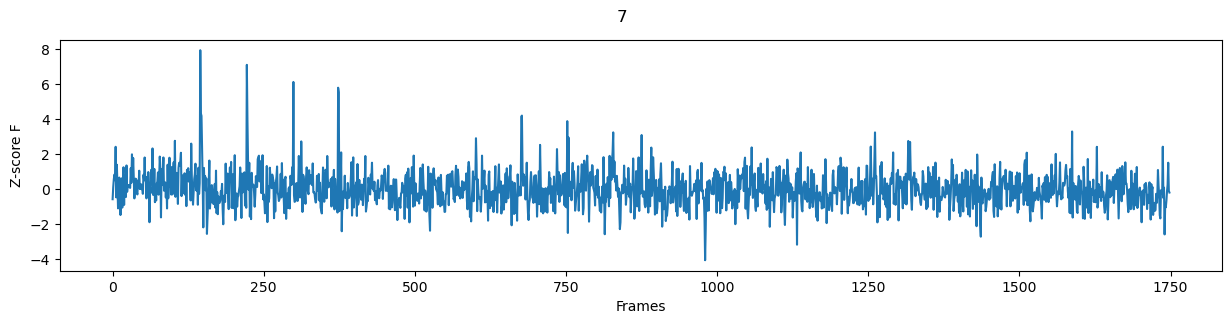

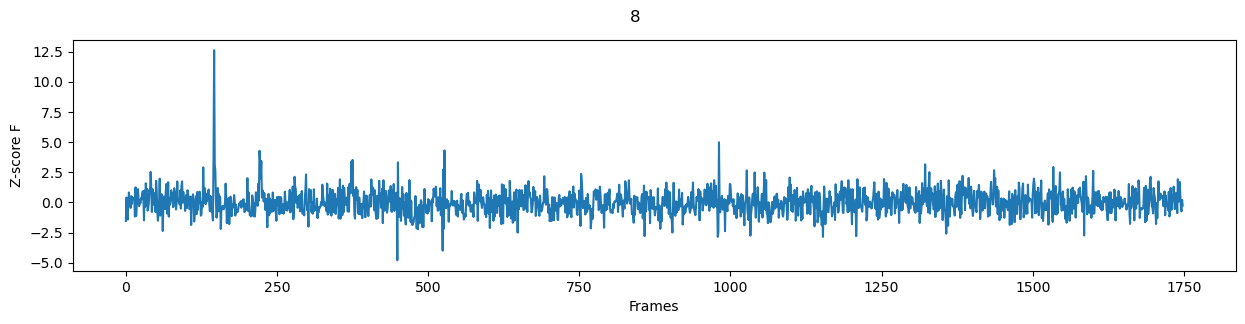

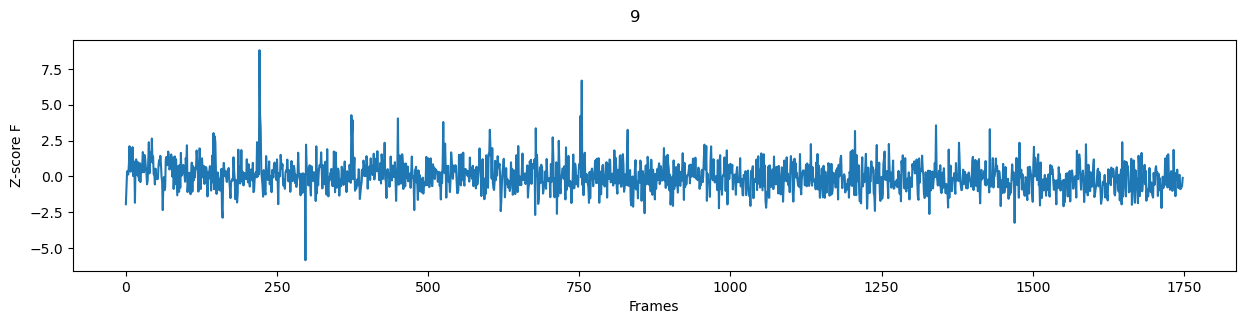

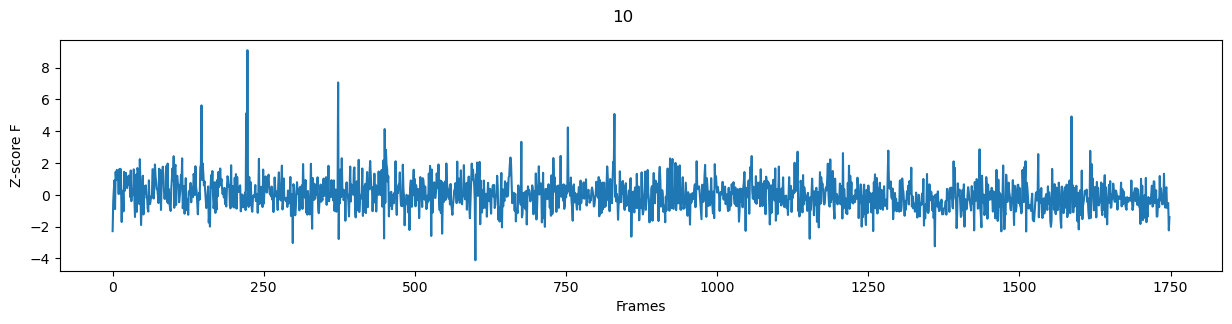

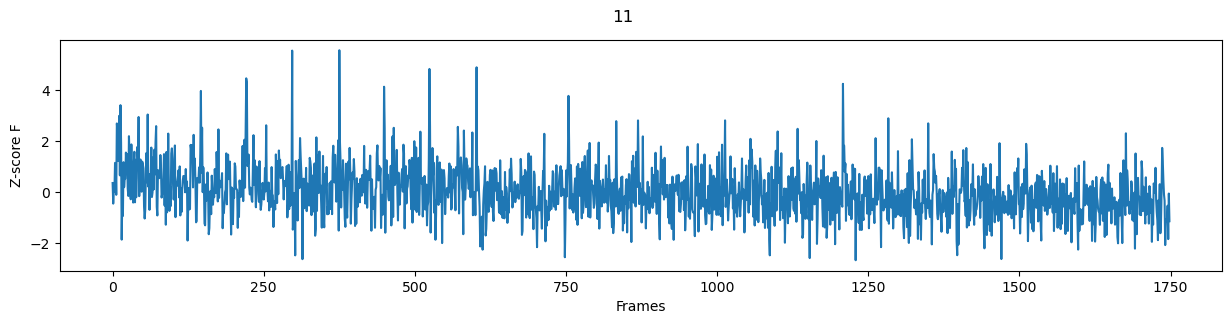

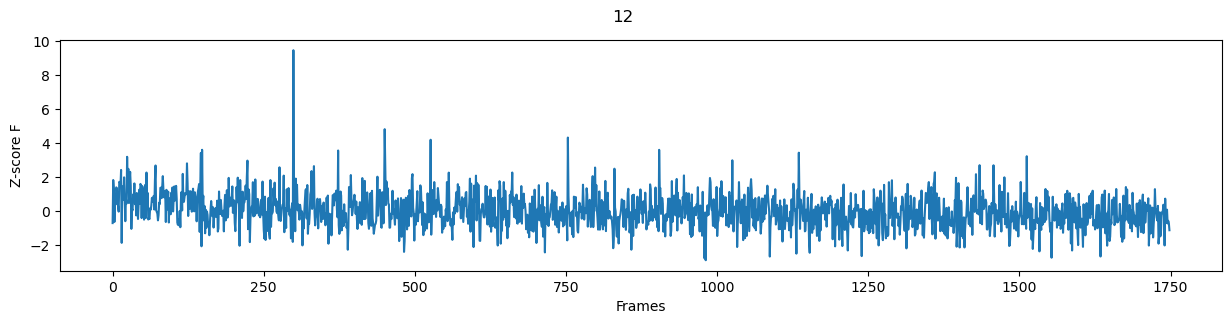

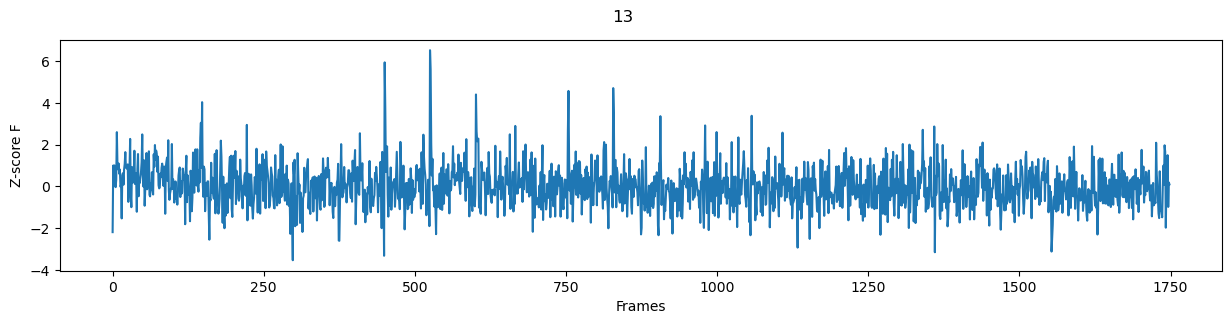

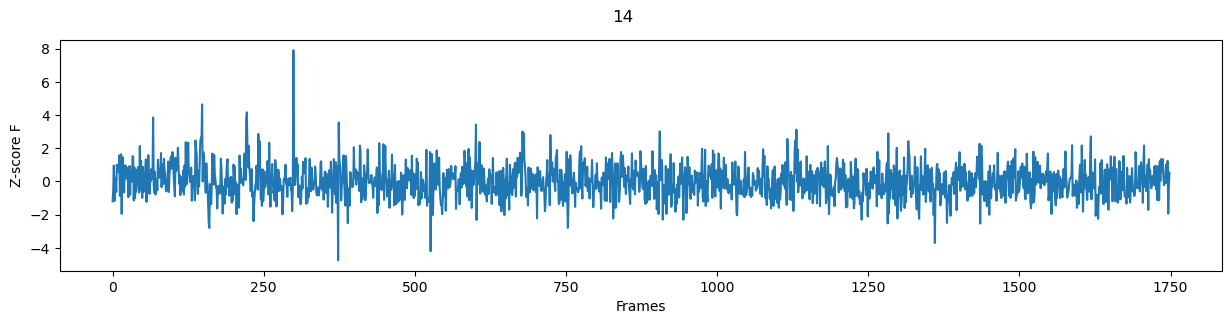

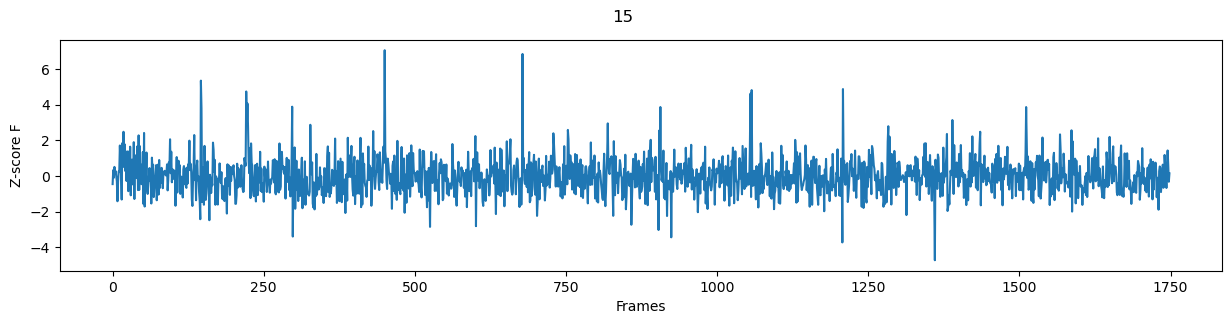

In [22]:
%matplotlib inline
for r in range(16):
    fig, ax = plt.subplots(figsize = [15,3])
    ax.plot(dff[r, :])
    fig.suptitle(f'{r}')
    ax.set_xlabel('Frames')
    ax.set_ylabel('Z-score F')